In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



 1/64 [..............................] - ETA: 1:40 - loss: 0.0237 - STD: 1.8042e-04 - MAE: 0.1370


 4/64 [>.............................] - ETA: 1s - loss: 0.0195 - STD: 2.1741e-04 - MAE: 0.1093  


 5/64 [=>............................] - ETA: 2s - loss: 0.0196 - STD: 2.1591e-04 - MAE: 0.1089


 6/64 [=>............................] - ETA: 2s - loss: 0.0191 - STD: 2.2254e-04 - MAE: 0.1065


 7/64 [==>...........................] - ETA: 2s - loss: 0.0183 - STD: 2.3724e-04 - MAE: 0.1031


 8/64 [==>...........................] - ETA: 7s - loss: 0.0181 - STD: 2.5854e-04 - MAE: 0.0997


11/64 [====>.........................] - ETA: 5s - loss: 0.0165 - STD: 3.5358e-04 - MAE: 0.0983


13/64 [=====>........................] - ETA: 4s - loss: 0.0157 - STD: 4.1040e-04 - MAE: 0.0973


14/64 [=====>........................] - ETA: 4s - loss: 0.0153 - STD: 4.3219e-04 - MAE: 0.0960


15/64 [======>.......................] - ETA: 4s - loss: 0.0149 - STD: 4.5010e-04 - MAE: 0.0947


16/64 [======>.......................] - ETA: 4s - loss: 0.0146 - STD: 4.6443e-04 - MAE: 0.0936


17/64 [======>.......................] - ETA: 3s - loss: 0.0145 - STD: 4.7711e-04 - MAE: 0.0927


18/64 [=======>......................] - ETA: 3s - loss: 0.0143 - STD: 4.8988e-04 - MAE: 0.0919


19/64 [=======>......................] - ETA: 3s - loss: 0.0142 - STD: 5.0297e-04 - MAE: 0.0912


20/64 [========>.....................] - ETA: 3s - loss: 0.0140 - STD: 5.1766e-04 - MAE: 0.0904


21/64 [========>.....................] - ETA: 3s - loss: 0.0138 - STD: 5.3471e-04 - MAE: 0.0897


22/64 [=========>....................] - ETA: 3s - loss: 0.0136 - STD: 5.5391e-04 - MAE: 0.0891


23/64 [=========>....................] - ETA: 3s - loss: 0.0135 - STD: 5.7601e-04 - MAE: 0.0886


24/64 [==========>...................] - ETA: 3s - loss: 0.0133 - STD: 5.9975e-04 - MAE: 0.0883


25/64 [==========>...................] - ETA: 3s - loss: 0.0132 - STD: 6.2433e-04 - MAE: 0.0882


26/64 [===========>..................] - ETA: 3s - loss: 0.0131 - STD: 6.4990e-04 - MAE: 0.0881


27/64 [===========>..................] - ETA: 2s - loss: 0.0130 - STD: 6.7483e-04 - MAE: 0.0879


28/64 [============>.................] - ETA: 2s - loss: 0.0129 - STD: 6.9906e-04 - MAE: 0.0877


29/64 [============>.................] - ETA: 2s - loss: 0.0128 - STD: 7.2222e-04 - MAE: 0.0874


30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 7.4319e-04 - MAE: 0.0871


31/64 [=============>................] - ETA: 2s - loss: 0.0126 - STD: 7.6384e-04 - MAE: 0.0867


32/64 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 7.8344e-04 - MAE: 0.0864


33/64 [==============>...............] - ETA: 2s - loss: 0.0124 - STD: 8.0300e-04 - MAE: 0.0861


34/64 [==============>...............] - ETA: 2s - loss: 0.0124 - STD: 8.2298e-04 - MAE: 0.0857


35/64 [===============>..............] - ETA: 2s - loss: 0.0123 - STD: 8.4385e-04 - MAE: 0.0854


36/64 [===============>..............] - ETA: 2s - loss: 0.0122 - STD: 8.6692e-04 - MAE: 0.0852


37/64 [================>.............] - ETA: 2s - loss: 0.0122 - STD: 8.9270e-04 - MAE: 0.0850


38/64 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 9.2041e-04 - MAE: 0.0848


39/64 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 9.5028e-04 - MAE: 0.0846


40/64 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 9.8142e-04 - MAE: 0.0845


41/64 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0844    


42/64 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0843


43/64 [===================>..........] - ETA: 1s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0842


44/64 [===================>..........] - ETA: 1s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0841


45/64 [====================>.........] - ETA: 1s - loss: 0.0117 - STD: 0.0012 - MAE: 0.0839


46/64 [====================>.........] - ETA: 1s - loss: 0.0117 - STD: 0.0012 - MAE: 0.0837


47/64 [=====================>........] - ETA: 1s - loss: 0.0116 - STD: 0.0012 - MAE: 0.0836


48/64 [=====================>........] - ETA: 1s - loss: 0.0116 - STD: 0.0013 - MAE: 0.0834


49/64 [=====================>........] - ETA: 1s - loss: 0.0116 - STD: 0.0013 - MAE: 0.0833


50/64 [======================>.......] - ETA: 1s - loss: 0.0115 - STD: 0.0013 - MAE: 0.0831


51/64 [======================>.......] - ETA: 0s - loss: 0.0115 - STD: 0.0014 - MAE: 0.0830


52/64 [=======================>......] - ETA: 0s - loss: 0.0115 - STD: 0.0014 - MAE: 0.0829


53/64 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 0.0015 - MAE: 0.0828


54/64 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.0015 - MAE: 0.0827


55/64 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0826


56/64 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0826


57/64 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0825


58/64 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0824


59/64 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 0.0019 - MAE: 0.0822


60/64 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0019 - MAE: 0.0821


61/64 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0020 - MAE: 0.0820


62/64 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0021 - MAE: 0.0819


63/64 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0022 - MAE: 0.0818


64/64 [==============================] - ETA: 0s - loss: 0.0111 - STD: 0.0023 - MAE: 0.0817


64/64 [==============================] - 7s 84ms/step - loss: 0.0111 - STD: 0.0023 - MAE: 0.0817 - val_loss: 0.0088 - val_STD: 0.0072 - val_MAE: 0.0742


Epoch 2/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0095 - STD: 0.0090 - MAE: 0.0763


 2/64 [..............................] - ETA: 4s - loss: 0.0093 - STD: 0.0093 - MAE: 0.0760


 3/64 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 0.0097 - MAE: 0.0759


 4/64 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 0.0101 - MAE: 0.0760


 5/64 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 0.0105 - MAE: 0.0760


 6/64 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 0.0109 - MAE: 0.0760


 7/64 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 0.0113 - MAE: 0.0760


 8/64 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 0.0117 - MAE: 0.0758


 9/64 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 0.0121 - MAE: 0.0757


10/64 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.0125 - MAE: 0.0755


11/64 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0130 - MAE: 0.0753


12/64 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0135 - MAE: 0.0751


13/64 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0140 - MAE: 0.0749


14/64 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0146 - MAE: 0.0748


15/64 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0151 - MAE: 0.0747


16/64 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0157 - MAE: 0.0746


17/64 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0163 - MAE: 0.0745


18/64 [=======>......................] - ETA: 3s - loss: 0.0089 - STD: 0.0169 - MAE: 0.0744


19/64 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0175 - MAE: 0.0743


20/64 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0181 - MAE: 0.0741


21/64 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0187 - MAE: 0.0740


23/64 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.0200 - MAE: 0.0737


24/64 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0206 - MAE: 0.0736


25/64 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0212 - MAE: 0.0735


26/64 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0218 - MAE: 0.0734


27/64 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0223 - MAE: 0.0734


28/64 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.0229 - MAE: 0.0733


29/64 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0234 - MAE: 0.0732


30/64 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0239 - MAE: 0.0731


31/64 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0243 - MAE: 0.0730


32/64 [==============>...............] - ETA: 2s - loss: 0.0086 - STD: 0.0248 - MAE: 0.0729


33/64 [==============>...............] - ETA: 2s - loss: 0.0086 - STD: 0.0252 - MAE: 0.0729


34/64 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0255 - MAE: 0.0728


35/64 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.0259 - MAE: 0.0727


36/64 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.0262 - MAE: 0.0727


37/64 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0265 - MAE: 0.0726


38/64 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0268 - MAE: 0.0725


39/64 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0271 - MAE: 0.0725


40/64 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0273 - MAE: 0.0724


41/64 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0276 - MAE: 0.0723


42/64 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0278 - MAE: 0.0723


43/64 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0280 - MAE: 0.0722


44/64 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0283 - MAE: 0.0722


45/64 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0285 - MAE: 0.0721


46/64 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0287 - MAE: 0.0721


47/64 [=====================>........] - ETA: 1s - loss: 0.0084 - STD: 0.0290 - MAE: 0.0720


48/64 [=====================>........] - ETA: 1s - loss: 0.0084 - STD: 0.0292 - MAE: 0.0720


49/64 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0295 - MAE: 0.0719


50/64 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0297 - MAE: 0.0718


51/64 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0300 - MAE: 0.0718


52/64 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0302 - MAE: 0.0717


53/64 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0304 - MAE: 0.0717


54/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0307 - MAE: 0.0716


55/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0309 - MAE: 0.0715


56/64 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0311 - MAE: 0.0715


57/64 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0313 - MAE: 0.0715


58/64 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0315 - MAE: 0.0714


59/64 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0317 - MAE: 0.0713


60/64 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0318 - MAE: 0.0713


61/64 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0320 - MAE: 0.0712


62/64 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0322 - MAE: 0.0712


63/64 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0323 - MAE: 0.0711


64/64 [==============================] - ETA: 0s - loss: 0.0083 - STD: 0.0325 - MAE: 0.0711


64/64 [==============================] - 5s 70ms/step - loss: 0.0083 - STD: 0.0325 - MAE: 0.0711 - val_loss: 0.0073 - val_STD: 0.0319 - val_MAE: 0.0656


Epoch 3/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0078 - STD: 0.0426 - MAE: 0.0679


 2/64 [..............................] - ETA: 4s - loss: 0.0078 - STD: 0.0427 - MAE: 0.0682


 3/64 [>.............................] - ETA: 4s - loss: 0.0077 - STD: 0.0427 - MAE: 0.0675


 4/64 [>.............................] - ETA: 4s - loss: 0.0077 - STD: 0.0428 - MAE: 0.0675


 5/64 [=>............................] - ETA: 4s - loss: 0.0076 - STD: 0.0429 - MAE: 0.0673


 6/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0430 - MAE: 0.0671


 7/64 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.0430 - MAE: 0.0671


 8/64 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.0432 - MAE: 0.0671


 9/64 [===>..........................] - ETA: 3s - loss: 0.0076 - STD: 0.0432 - MAE: 0.0671


10/64 [===>..........................] - ETA: 3s - loss: 0.0076 - STD: 0.0434 - MAE: 0.0671


11/64 [====>.........................] - ETA: 3s - loss: 0.0076 - STD: 0.0435 - MAE: 0.0671


12/64 [====>.........................] - ETA: 3s - loss: 0.0076 - STD: 0.0436 - MAE: 0.0670


13/64 [=====>........................] - ETA: 3s - loss: 0.0076 - STD: 0.0437 - MAE: 0.0669


14/64 [=====>........................] - ETA: 3s - loss: 0.0076 - STD: 0.0437 - MAE: 0.0668


15/64 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.0438 - MAE: 0.0667


16/64 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.0439 - MAE: 0.0666


17/64 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.0440 - MAE: 0.0665


18/64 [=======>......................] - ETA: 3s - loss: 0.0075 - STD: 0.0441 - MAE: 0.0664


19/64 [=======>......................] - ETA: 3s - loss: 0.0075 - STD: 0.0442 - MAE: 0.0663


20/64 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0442 - MAE: 0.0662


21/64 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0443 - MAE: 0.0661


22/64 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.0444 - MAE: 0.0660


23/64 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.0446 - MAE: 0.0659


24/64 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.0446 - MAE: 0.0658


25/64 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0448 - MAE: 0.0657


26/64 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0450 - MAE: 0.0656


27/64 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0451 - MAE: 0.0655


28/64 [============>.................] - ETA: 2s - loss: 0.0073 - STD: 0.0453 - MAE: 0.0654


29/64 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.0455 - MAE: 0.0653


30/64 [=============>................] - ETA: 2s - loss: 0.0072 - STD: 0.0456 - MAE: 0.0652


31/64 [=============>................] - ETA: 2s - loss: 0.0072 - STD: 0.0458 - MAE: 0.0650


32/64 [==============>...............] - ETA: 2s - loss: 0.0072 - STD: 0.0461 - MAE: 0.0649


33/64 [==============>...............] - ETA: 2s - loss: 0.0072 - STD: 0.0463 - MAE: 0.0648


34/64 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0466 - MAE: 0.0647


35/64 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0467 - MAE: 0.0646


36/64 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0471 - MAE: 0.0646


37/64 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0472 - MAE: 0.0645


38/64 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0474 - MAE: 0.0644


39/64 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0477 - MAE: 0.0645


40/64 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0478 - MAE: 0.0644


41/64 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0479 - MAE: 0.0643


42/64 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0483 - MAE: 0.0644


43/64 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0484 - MAE: 0.0642


44/64 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0484 - MAE: 0.0641


45/64 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0487 - MAE: 0.0641


46/64 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0489 - MAE: 0.0641


47/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0490 - MAE: 0.0640


48/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0491 - MAE: 0.0638


49/64 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0493 - MAE: 0.0638


50/64 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0495 - MAE: 0.0638


51/64 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0495 - MAE: 0.0637


52/64 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0496 - MAE: 0.0636


54/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0500 - MAE: 0.0636


55/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0500 - MAE: 0.0635


56/64 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0501 - MAE: 0.0634


57/64 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0503 - MAE: 0.0634


58/64 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0504 - MAE: 0.0634


59/64 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0505 - MAE: 0.0633


60/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0506 - MAE: 0.0632


61/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0507 - MAE: 0.0631


62/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0508 - MAE: 0.0631


63/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0509 - MAE: 0.0630


64/64 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0510 - MAE: 0.0629


64/64 [==============================] - 4s 69ms/step - loss: 0.0068 - STD: 0.0510 - MAE: 0.0629 - val_loss: 0.0055 - val_STD: 0.0513 - val_MAE: 0.0581


Epoch 4/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0598


 2/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0591


 3/64 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0578 - MAE: 0.0584


 4/64 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0583


 5/64 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0584 - MAE: 0.0586


 6/64 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0583 - MAE: 0.0582


 7/64 [==>...........................] - ETA: 4s - loss: 0.0059 - STD: 0.0580 - MAE: 0.0580


 8/64 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0584 - MAE: 0.0582


 9/64 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0587 - MAE: 0.0583


10/64 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0586 - MAE: 0.0581


11/64 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0587 - MAE: 0.0581


12/64 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0591 - MAE: 0.0581


13/64 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0591 - MAE: 0.0580


14/64 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0592 - MAE: 0.0580


15/64 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0595 - MAE: 0.0581


16/64 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0596 - MAE: 0.0581


17/64 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0597 - MAE: 0.0580


18/64 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0599 - MAE: 0.0580


19/64 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0600 - MAE: 0.0580


20/64 [========>.....................] - ETA: 3s - loss: 0.0059 - STD: 0.0600 - MAE: 0.0579


21/64 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0579


22/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0578


23/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0578


24/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0605 - MAE: 0.0578


25/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0605 - MAE: 0.0577


26/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0606 - MAE: 0.0576


27/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0607 - MAE: 0.0576


28/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0608 - MAE: 0.0575


29/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0608 - MAE: 0.0574


30/64 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0609 - MAE: 0.0574


31/64 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0610 - MAE: 0.0574


32/64 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0610 - MAE: 0.0573


33/64 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0612 - MAE: 0.0573


35/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0613 - MAE: 0.0572


36/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0613 - MAE: 0.0571


37/64 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0615 - MAE: 0.0572


38/64 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0613 - MAE: 0.0572


39/64 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0615 - MAE: 0.0572


40/64 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0615 - MAE: 0.0571


41/64 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0616 - MAE: 0.0571


42/64 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0617 - MAE: 0.0570


43/64 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0616 - MAE: 0.0570


44/64 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0618 - MAE: 0.0570


45/64 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0617 - MAE: 0.0569


46/64 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0618 - MAE: 0.0569


47/64 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0619 - MAE: 0.0569


48/64 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0619 - MAE: 0.0568


49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0620 - MAE: 0.0568


50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0620 - MAE: 0.0568


51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0620 - MAE: 0.0568


52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0567


53/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0621 - MAE: 0.0567


54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0622 - MAE: 0.0567


55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0621 - MAE: 0.0566


56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0567


57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0566


58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0566


59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0624 - MAE: 0.0565


60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0624 - MAE: 0.0565


61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0565


62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0625 - MAE: 0.0565


63/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0566


64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0565


64/64 [==============================] - 5s 70ms/step - loss: 0.0056 - STD: 0.0627 - MAE: 0.0565 - val_loss: 0.0052 - val_STD: 0.0532 - val_MAE: 0.0535


Epoch 5/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0541


 2/64 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0660 - MAE: 0.0565


 3/64 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0558


 4/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0642 - MAE: 0.0554


 5/64 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557


 6/64 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0557


 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0558


 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0556


 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0554


10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0554


11/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0551


12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0549


13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0550


14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0548


15/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0548


16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0548


17/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0547


18/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0547


19/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0546


20/64 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0546


21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0546


22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0545


23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0545


24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0544


25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0544


26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0543


27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0543


28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0543


29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0542


30/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0542


31/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0542


33/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0543


34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0544


35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0543


36/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0543


37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0543


38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0543


39/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0543


40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0543


41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0542


42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0542


43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0542


44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0542


45/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0542


46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0542


47/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0542


48/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0542


49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0542


50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0542


51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0541


52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0541


53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0541


54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0540


55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0541


56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540


57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540


58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0540


59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540


60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0540


61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540


62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0540


63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0540


64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540


64/64 [==============================] - 5s 70ms/step - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540 - val_loss: 0.0047 - val_STD: 0.0645 - val_MAE: 0.0542


Epoch 6/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0743 - MAE: 0.0563


 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0538


 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0532


 4/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0537


 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0534


 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0535


 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0535


 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0536


 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0539


10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0537


11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536


12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0538


13/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0537


14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0537


15/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0537


16/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0536


17/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536


18/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536


19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0534


20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0535


21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0534


22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0533


23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0533


24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0532


25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531


26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531


27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531


28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531


29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0530


30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0530


31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529


32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0529


33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529


34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528


35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529


36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528


37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0528


38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0528


40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0528


41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0527


42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0528


43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0528


44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528


45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0528


46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528


47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0528


48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0527


50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528


52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0527


55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0527


57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0527


60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526


61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526


62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526


63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0526


64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526


64/64 [==============================] - 4s 68ms/step - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526 - val_loss: 0.0047 - val_STD: 0.0571 - val_MAE: 0.0508


Epoch 7/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0509


 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0513


 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0514


 4/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0513


 5/64 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0517


 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0515


 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0515


 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0514


 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0513


11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513


12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0514


13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0513


14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0514


15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0514


16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0514


17/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


18/64 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0513


19/64 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512


20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512


21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512


22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512


23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513


24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0514


25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0516


26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517


27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0518


28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518


29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517


30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518


31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0519


33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0519


34/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518


40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517


41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517


42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517


43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517


44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517


45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517


46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517


47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517


48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516


49/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516


50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516


51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516


52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516


56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516


57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517


58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516


59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516


64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516


64/64 [==============================] - 5s 71ms/step - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516 - val_loss: 0.0045 - val_STD: 0.0584 - val_MAE: 0.0500


Epoch 8/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0495


 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0511


 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0507


 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0514


 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0512


 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0514


 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511


 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511


 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509


11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0514


12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519


13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0522


14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0521


15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0520


16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0523


17/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523


18/64 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523


19/64 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523


20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523


21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523


22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0523


23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0522


24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523


25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523


26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0522


27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0522


28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0522


29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0521


30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0521


31/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0521


32/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520


33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0520


34/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0519


35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0519


36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0519


37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0518


38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0518


39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0518


40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0517


41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0517


42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0517


43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0516


44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0516


45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0516


46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0516


47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516


48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515


49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515


50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0515


51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515


52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0515


53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0515


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0515


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0515


56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0514


57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0515


58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0515


59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0515


60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0515


61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


64/64 [==============================] - 4s 69ms/step - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516 - val_loss: 0.0043 - val_STD: 0.0642 - val_MAE: 0.0514


Epoch 9/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0743 - MAE: 0.0521


 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512


 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0517


 4/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512


 5/64 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512


 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0510


 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508


 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509


 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0510


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509


11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0511


12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0509


13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0508


14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508


15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0507


16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507


17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507


18/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0506


19/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507


20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506


21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506


22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506


23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505


24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505


25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505


26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505


27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504


28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504


29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504


32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504


33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504


34/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504


36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504


38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505


39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0506


40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507


41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0507


42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0507


43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507


44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0508


45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509


46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509


47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0509


48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510


49/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510


50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511


51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0512


52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511


53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0514


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0516


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516


56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522


57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0524


58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0527


59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0527


60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0698 - MAE: 0.0535


62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0686 - MAE: 0.0541


63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0679 - MAE: 0.0543


64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0676 - MAE: 0.0544


64/64 [==============================] - 4s 69ms/step - loss: 0.0054 - STD: 0.0676 - MAE: 0.0544 - val_loss: 0.0107 - val_STD: 0.0528 - val_MAE: 0.0926


Epoch 10/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0112 - STD: 0.0607 - MAE: 0.0935


 2/64 [..............................] - ETA: 4s - loss: 0.0087 - STD: 0.0541 - MAE: 0.0797


 3/64 [>.............................] - ETA: 4s - loss: 0.0081 - STD: 0.0466 - MAE: 0.0728


 4/64 [>.............................] - ETA: 4s - loss: 0.0084 - STD: 0.0414 - MAE: 0.0714


 5/64 [=>............................] - ETA: 4s - loss: 0.0084 - STD: 0.0384 - MAE: 0.0701


 6/64 [=>............................] - ETA: 4s - loss: 0.0081 - STD: 0.0374 - MAE: 0.0684


 7/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0380 - MAE: 0.0685


 8/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0696


 9/64 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.0396 - MAE: 0.0694


10/64 [===>..........................] - ETA: 3s - loss: 0.0076 - STD: 0.0394 - MAE: 0.0686


11/64 [====>.........................] - ETA: 3s - loss: 0.0075 - STD: 0.0388 - MAE: 0.0678


12/64 [====>.........................] - ETA: 3s - loss: 0.0075 - STD: 0.0385 - MAE: 0.0673


13/64 [=====>........................] - ETA: 3s - loss: 0.0074 - STD: 0.0387 - MAE: 0.0666


14/64 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0395 - MAE: 0.0662


15/64 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0407 - MAE: 0.0662


16/64 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0417 - MAE: 0.0660


17/64 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0422 - MAE: 0.0656


18/64 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0425 - MAE: 0.0650


19/64 [=======>......................] - ETA: 3s - loss: 0.0069 - STD: 0.0427 - MAE: 0.0646


20/64 [========>.....................] - ETA: 2s - loss: 0.0069 - STD: 0.0433 - MAE: 0.0641


21/64 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.0442 - MAE: 0.0639


22/64 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.0452 - MAE: 0.0638


23/64 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0459 - MAE: 0.0634


24/64 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0463 - MAE: 0.0630


25/64 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0466 - MAE: 0.0627


26/64 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0471 - MAE: 0.0623


27/64 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0478 - MAE: 0.0621


28/64 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0484 - MAE: 0.0619


29/64 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0488 - MAE: 0.0616


30/64 [=============>................] - ETA: 2s - loss: 0.0063 - STD: 0.0491 - MAE: 0.0612


31/64 [=============>................] - ETA: 2s - loss: 0.0063 - STD: 0.0494 - MAE: 0.0609


32/64 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.0499 - MAE: 0.0607


33/64 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.0504 - MAE: 0.0606


34/64 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.0508 - MAE: 0.0603


36/64 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0515 - MAE: 0.0599


37/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0519 - MAE: 0.0597


38/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0524 - MAE: 0.0595


39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0527 - MAE: 0.0593


40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0530 - MAE: 0.0591


41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0534 - MAE: 0.0589


42/64 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0539 - MAE: 0.0587


43/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0543 - MAE: 0.0586


44/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0547 - MAE: 0.0584


45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0550 - MAE: 0.0582


46/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0555 - MAE: 0.0581


47/64 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0559 - MAE: 0.0580


48/64 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0562 - MAE: 0.0578


49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0577


50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0568 - MAE: 0.0575


51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0572 - MAE: 0.0574


52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0575 - MAE: 0.0572


53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0571


54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0580 - MAE: 0.0570


55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0569


56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0568


57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0567


58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0566


59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0565


60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0564


61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0563


62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0562


63/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0561


64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0560


64/64 [==============================] - 4s 69ms/step - loss: 0.0055 - STD: 0.0603 - MAE: 0.0560 - val_loss: 0.0043 - val_STD: 0.0613 - val_MAE: 0.0496


Epoch 11/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0494


 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0496


 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0500


 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0501


 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0501


 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501


 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0501


 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0501


 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500


10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500


11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501


12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501


13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500


14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501


15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501


16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501


17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500


18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501


19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501


20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501


21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501


22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501


24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502


25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502


26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502


27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502


28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502


29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502


30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502


31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502


32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501


33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502


34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502


35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501


36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501


37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501


38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501


39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501


40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501


41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501


42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501


43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501


44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501


45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501


46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501


47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501


48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501


49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501


50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501


51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501


52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501


53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500


61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500


63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500


64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500


64/64 [==============================] - 5s 70ms/step - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500 - val_loss: 0.0042 - val_STD: 0.0636 - val_MAE: 0.0491


Epoch 12/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0491


 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494


 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495


 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0494


 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0496


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0497


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0496


12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496


13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495


14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495


15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495


16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495


17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495


18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495


19/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495


20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495


21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495


22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495


23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495


24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495


25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495


26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495


27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495


28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495


30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495


31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


34/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495


64/64 [==============================] - 4s 69ms/step - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495 - val_loss: 0.0048 - val_STD: 0.0555 - val_MAE: 0.0506


Epoch 13/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0499


 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0494


 3/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0726 - MAE: 0.0516


 4/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0516


 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0511


 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0525


 7/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0528


 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0524


 9/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0709 - MAE: 0.0541


10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0693 - MAE: 0.0542


11/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0680 - MAE: 0.0541


12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0690 - MAE: 0.0548


13/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0690 - MAE: 0.0545


14/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0681 - MAE: 0.0543


15/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0540


16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0544


17/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0542


18/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0540


19/64 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0539


20/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0539


21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0537


22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0536


23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0535


24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0534


25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0533


26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0532


27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0531


28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0531


29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0530


30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0528


31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0528


32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0527


33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0526


34/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0525


36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0525


37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0524


38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0523


39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0523


40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0522


41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0522


42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0521


43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0521


44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0520


45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0520


46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0520


47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0519


48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518


49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0518


50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0518


51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0517


52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0517


53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0517


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0516


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0515


56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0515


57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0515


58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0514


59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0514


60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514


61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0513


62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0513


63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0513


64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0512


64/64 [==============================] - 4s 69ms/step - loss: 0.0047 - STD: 0.0700 - MAE: 0.0512 - val_loss: 0.0041 - val_STD: 0.0636 - val_MAE: 0.0488


Epoch 14/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495


 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501


 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0498


 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495


 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494


 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493


 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493


12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495


14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493


15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494


16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494


19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493


26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493


27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492


29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492


30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492


31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492


32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492


33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492


34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492


43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492


44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492


45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493


46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493


47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493


48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495


51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0497


52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0498


53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0498


54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0502


55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0502


56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0503


57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0504


58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0505


59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0505


60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505


61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0506


62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0507


63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0507


64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507


64/64 [==============================] - 4s 69ms/step - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507 - val_loss: 0.0044 - val_STD: 0.0608 - val_MAE: 0.0530


Epoch 15/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0537


 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0537


 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0525


 4/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0518


 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0520


 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0522


 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519


 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0661 - MAE: 0.0516


 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0515


10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0515


11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0513


12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0511


13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0511


14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0511


15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0509


16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0508


17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0681 - MAE: 0.0508


18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507


19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506


20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0505


21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0690 - MAE: 0.0504


22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0504


23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0503


24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0503


25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0502


26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0501


27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0701 - MAE: 0.0501


28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0500


29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0500


30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0499


31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0499


32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0499


33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0499


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0499


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0498


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0498


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0498


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0497


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0497


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0497


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497


43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0496


44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0496


45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496


46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496


47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496


48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495


51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


64/64 [==============================] - 4s 67ms/step - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493 - val_loss: 0.0041 - val_STD: 0.0634 - val_MAE: 0.0480


Epoch 16/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0477


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0475


 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0481


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0480


 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484


13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0485


14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0485


15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0485


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0485


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0485


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0485


21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0485


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484


24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485


27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485


52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0484


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0484


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


64/64 [==============================] - 4s 62ms/step - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485 - val_loss: 0.0040 - val_STD: 0.0646 - val_MAE: 0.0476


Epoch 17/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477


 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0478


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0478


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483


12/64 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484


13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484


14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0485


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483


29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483


31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484


33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482


63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482


64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482 - val_loss: 0.0040 - val_STD: 0.0639 - val_MAE: 0.0472


Epoch 18/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0474


 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481


 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481


 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0486


 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0488


 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0487


 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484


13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484


29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484


30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0485


31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484


32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484


33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0484


35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0484


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484


39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482


63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482 - val_loss: 0.0039 - val_STD: 0.0674 - val_MAE: 0.0475


Epoch 19/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0486


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0483


 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482


 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0490


 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0494


 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497


 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0494


 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0492


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0496


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493


12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0495


13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495


14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494


15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0497


16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500


17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0499


18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0738 - MAE: 0.0505


19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0724 - MAE: 0.0513


20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0513


21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0535


22/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0551


23/64 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0575


24/64 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0590


25/64 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.0661 - MAE: 0.0587


26/64 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0663 - MAE: 0.0611


27/64 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0655 - MAE: 0.0611


28/64 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0642 - MAE: 0.0612


29/64 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0627 - MAE: 0.0615


30/64 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.0613 - MAE: 0.0618


31/64 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0601 - MAE: 0.0618


32/64 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0592 - MAE: 0.0620


33/64 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0584 - MAE: 0.0626


34/64 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0578 - MAE: 0.0632


35/64 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0571 - MAE: 0.0634


36/64 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0563 - MAE: 0.0635


37/64 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0555 - MAE: 0.0635


38/64 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0547 - MAE: 0.0636


39/64 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0541 - MAE: 0.0636


40/64 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0535 - MAE: 0.0635


41/64 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.0531 - MAE: 0.0636


42/64 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.0529 - MAE: 0.0637


43/64 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0528 - MAE: 0.0639


44/64 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0527 - MAE: 0.0640


45/64 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0525 - MAE: 0.0640


46/64 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0523 - MAE: 0.0639


47/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0521 - MAE: 0.0638


48/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0519 - MAE: 0.0638


49/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0518 - MAE: 0.0637


50/64 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0519 - MAE: 0.0636


52/64 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0521 - MAE: 0.0636


53/64 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0522 - MAE: 0.0636


54/64 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0522 - MAE: 0.0635


55/64 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0522 - MAE: 0.0634


56/64 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0521 - MAE: 0.0632


57/64 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0521 - MAE: 0.0631


58/64 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0521 - MAE: 0.0630


59/64 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0523 - MAE: 0.0629


60/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0524 - MAE: 0.0628


61/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0525 - MAE: 0.0627


62/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0524 - MAE: 0.0625


63/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0525 - MAE: 0.0624


64/64 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0526 - MAE: 0.0622


64/64 [==============================] - 4s 60ms/step - loss: 0.0068 - STD: 0.0526 - MAE: 0.0622 - val_loss: 0.0045 - val_STD: 0.0551 - val_MAE: 0.0527


Epoch 20/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0547


 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0547


 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0537


 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0530


 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0526


 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0525


 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0657 - MAE: 0.0524


 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0522


 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0520


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0518


11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0517


12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0517


13/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0516


14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0514


15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0514


16/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0514


17/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0513


18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0512


19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0511


20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0511


21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0510


22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509


23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508


24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0508


25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508


26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508


27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507


28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506


29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506


30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506


31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0505


32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0505


33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0504


34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504


35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504


36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503


37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503


38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503


39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503


40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502


41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502


42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502


43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501


44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501


45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500


46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500


47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500


48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500


49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500


50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500


51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0498


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497


64/64 [==============================] - 4s 61ms/step - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497 - val_loss: 0.0040 - val_STD: 0.0654 - val_MAE: 0.0480


Epoch 21/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484


 3/64 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0476


 4/64 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0479


 5/64 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0480


 6/64 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0480


 7/64 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


 9/64 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


10/64 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


11/64 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481


12/64 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481


13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481


14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480


33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480


34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478


63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478


64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478 - val_loss: 0.0039 - val_STD: 0.0663 - val_MAE: 0.0472


Epoch 22/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0473


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476


13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475 - val_loss: 0.0040 - val_STD: 0.0632 - val_MAE: 0.0469


Epoch 23/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0471


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0467


 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0471


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0473


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473


13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473


16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474


19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0477


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0477


30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0478


31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478


32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0477


33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0479


34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0486


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0487


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0492


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492


41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0493


42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0494


43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0496


44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0496


45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0496


46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0497


47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0498


48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0497


49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497


50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498


51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499


53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499


54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499


55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500


56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499


58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499


59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500


60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499


61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499


62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499


63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499


64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499


64/64 [==============================] - 4s 61ms/step - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499 - val_loss: 0.0044 - val_STD: 0.0579 - val_MAE: 0.0484


Epoch 24/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0656 - MAE: 0.0477


 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0481


 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0485


 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0483


 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0483


 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0484


 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0483


10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484


12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0483


13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0482


14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0483


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0482


18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0481


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0478


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0478


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478


42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478


43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478


45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475


64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475 - val_loss: 0.0038 - val_STD: 0.0681 - val_MAE: 0.0466


Epoch 25/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0790 - MAE: 0.0476


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0788 - MAE: 0.0480


 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0477


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0475


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0476


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0475


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0474


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0474


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0473


13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0472


14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0472


15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472


16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0472


17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0472


18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0472


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0473


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0472


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0472


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0472


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0472


30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0473


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0473


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0473


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0477


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0478


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0478


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0482


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0482


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0483


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484


47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0485


48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0484


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0485


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485


52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0486


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0485


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


64/64 [==============================] - 4s 60ms/step - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485 - val_loss: 0.0040 - val_STD: 0.0628 - val_MAE: 0.0470


Epoch 26/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0470


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0470


 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0476


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0474


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0472


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0472


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0475


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0474


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0473


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0474


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0475


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0474


13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0473


14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0473


15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0473


16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0473


17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0473


18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473


19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0471


30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471


31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472


32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471


36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471


38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471


47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


64/64 [==============================] - 4s 59ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470 - val_loss: 0.0038 - val_STD: 0.0678 - val_MAE: 0.0463


Epoch 27/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0467


 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0470


 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0469


 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0471


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469


 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0469


 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468


10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467


11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468


12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467


13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467


14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468


15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467


16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467


17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468


18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0469


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0471


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0471


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475


30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0476


31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0476


32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0482


33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0484


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0485


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0489


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0489


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0489


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0491


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0490


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0490


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0490


43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0492


44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0491


45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491


46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491


47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491


48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491


51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0490


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0490


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0489


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0489


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489


64/64 [==============================] - 4s 59ms/step - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489 - val_loss: 0.0039 - val_STD: 0.0638 - val_MAE: 0.0465


Epoch 28/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0471


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0477


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0473


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474


10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0473


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0473


13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0473


14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473


15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472


16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0473


17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472


18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


29/64 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474


31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0472


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0472


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471


47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


64/64 [==============================] - 4s 60ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469 - val_loss: 0.0037 - val_STD: 0.0693 - val_MAE: 0.0463


Epoch 29/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0467


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464


 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0465


 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463


 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0465


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0464


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464


15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465


18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0465


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0465


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0465


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0466


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0466


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0466


64/64 [==============================] - 4s 61ms/step - loss: 0.0040 - STD: 0.0771 - MAE: 0.0466 - val_loss: 0.0037 - val_STD: 0.0702 - val_MAE: 0.0468


Epoch 30/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0471


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0462


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0460


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0468


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0469


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0475


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0767 - MAE: 0.0492


11/64 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0500


12/64 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0735 - MAE: 0.0502


13/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0517


14/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0516


15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0727 - MAE: 0.0516


16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0729 - MAE: 0.0516


17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0732 - MAE: 0.0519


18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0724 - MAE: 0.0518


19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0517


20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0719 - MAE: 0.0517


21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0722 - MAE: 0.0518


22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0718 - MAE: 0.0517


23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0515


24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0514


25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0516


26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0515


27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0514


28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0512


29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0512


30/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511


31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510


32/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509


33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0509


34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0508


35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0507


36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0506


37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0505


38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505


39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0504


40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0503


41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0502


42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0502


43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0501


44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0500


45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0500


46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0499


48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0498


49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0497


50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497


51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0496


52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0495


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0495


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0494


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0493


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0493


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0491


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0491


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0490


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0490


64/64 [==============================] - 4s 59ms/step - loss: 0.0044 - STD: 0.0727 - MAE: 0.0490 - val_loss: 0.0038 - val_STD: 0.0642 - val_MAE: 0.0459


Epoch 31/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0466


 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0463


 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0465


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0465


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464


12/64 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463


13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461


31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


64/64 [==============================] - 4s 59ms/step - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462 - val_loss: 0.0039 - val_STD: 0.0730 - val_MAE: 0.0481


Epoch 32/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0823 - MAE: 0.0491


 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0473


 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0476


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0473


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0472


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0471


13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0471


14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470


15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469


17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466


27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466


28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465


29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0465


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0465


31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464


33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


64/64 [==============================] - 4s 61ms/step - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462 - val_loss: 0.0037 - val_STD: 0.0677 - val_MAE: 0.0453


Epoch 33/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460


 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0457


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0462


 5/64 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461


 6/64 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460


 7/64 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0461


 8/64 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0463


 9/64 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0462


10/64 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461


11/64 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461


12/64 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461


13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460


14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460


15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460


17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460


18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460


19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459


29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460


64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460 - val_loss: 0.0036 - val_STD: 0.0694 - val_MAE: 0.0459


Epoch 34/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0469


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


12/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457


64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0673 - val_MAE: 0.0450


Epoch 35/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


11/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454


12/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454


13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455


14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456


29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456


30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457


64/64 [==============================] - 4s 60ms/step - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0669 - val_MAE: 0.0450


Epoch 36/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0452


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460


 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458


 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460


 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463


18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459


30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460


31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459


33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458


64/64 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0683 - val_MAE: 0.0449


Epoch 37/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0457


 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0458


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455 - val_loss: 0.0036 - val_STD: 0.0674 - val_MAE: 0.0450


Epoch 38/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0448


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446


 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453 - val_loss: 0.0039 - val_STD: 0.0639 - val_MAE: 0.0456


Epoch 39/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0450


 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455


64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0699 - val_MAE: 0.0452


Epoch 40/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0454


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0454


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0709 - val_MAE: 0.0449


Epoch 41/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0813 - MAE: 0.0454


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0453


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448


14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448


15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448


17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448


18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451


33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450


64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0703 - val_MAE: 0.0448


Epoch 42/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0809 - MAE: 0.0453


 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0447


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446


 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0450


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0451


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0451


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449


64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449 - val_loss: 0.0036 - val_STD: 0.0735 - val_MAE: 0.0461


Epoch 43/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0459


 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0455


 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0460


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455


 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0454


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0458


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0459


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0463


15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461


16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0465


17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0470


18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0469


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0778 - MAE: 0.0479


20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0759 - MAE: 0.0495


21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0507


22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0512


23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0515


24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0516


25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0726 - MAE: 0.0517


26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0725 - MAE: 0.0517


27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0727 - MAE: 0.0523


28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0522


29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0711 - MAE: 0.0523


30/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0706 - MAE: 0.0523


31/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0706 - MAE: 0.0525


32/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0706 - MAE: 0.0527


33/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0702 - MAE: 0.0526


34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0526


35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0525


36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526


37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0527


38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526


39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0526


40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0525


41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0525


42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0525


43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0524


44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0523


45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0522


46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0522


47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0521


48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0520


49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0519


50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0518


51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0518


52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0517


53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0516


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0516


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0515


56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0514


57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0514


58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0513


59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0512


60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0511


61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0510


62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0509


63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0509


64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0508


64/64 [==============================] - 4s 69ms/step - loss: 0.0047 - STD: 0.0697 - MAE: 0.0508 - val_loss: 0.0037 - val_STD: 0.0637 - val_MAE: 0.0451


Epoch 44/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0449


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0453


 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0456


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0458


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0457


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0457


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0456


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0455


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0455


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0455


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453


15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0452


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0452


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0451


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0451


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0451


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0451


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0451


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0451


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0450


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451


32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0452


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0452


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457


64/64 [==============================] - 4s 67ms/step - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0699 - val_MAE: 0.0457


Epoch 45/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0466


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0459


 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0698 - val_MAE: 0.0444


Epoch 46/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


28/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446


64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446 - val_loss: 0.0037 - val_STD: 0.0661 - val_MAE: 0.0446


Epoch 47/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0433


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0444


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0443


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445


12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


28/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446


30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446


31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446


32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0457


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0467


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0470


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0471


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0475


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0477


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0480


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0480


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0484


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0485


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0485


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0486


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0486


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0488


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0489


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0489


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490


64/64 [==============================] - 4s 59ms/step - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490 - val_loss: 0.0050 - val_STD: 0.0467 - val_MAE: 0.0512


Epoch 48/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0553 - MAE: 0.0504


 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0597 - MAE: 0.0506


 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0527


 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0526


 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0638 - MAE: 0.0518


 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0625 - MAE: 0.0514


 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0624 - MAE: 0.0509


 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0635 - MAE: 0.0510


 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0645 - MAE: 0.0511


10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0646 - MAE: 0.0507


11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0644 - MAE: 0.0505


12/64 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0646 - MAE: 0.0502


13/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0501


14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0501


15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0499


16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0497


17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0495


18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0494


19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0494


20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0493


21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491


22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0490


23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0489


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0486


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0485


28/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0483


29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0482


30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0482


31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0481


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0480


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0479


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0478


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0477


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0477


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0475


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0475


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0474


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471


46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0470


47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0470


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0469


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0468


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0468


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0467


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0467


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0467


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0465


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0465


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0465


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0464


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0463


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463


64/64 [==============================] - 4s 58ms/step - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463 - val_loss: 0.0035 - val_STD: 0.0711 - val_MAE: 0.0446


Epoch 49/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0822 - MAE: 0.0446


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0441


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446


12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


64/64 [==============================] - 4s 59ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443 - val_loss: 0.0035 - val_STD: 0.0707 - val_MAE: 0.0445


Epoch 50/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0440


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


28/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


64/64 [==============================] - 4s 59ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441 - val_loss: 0.0035 - val_STD: 0.0685 - val_MAE: 0.0441


Epoch 51/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0439


 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0442


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0440


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0438


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0439


 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0439


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0440


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0440


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


64/64 [==============================] - 4s 59ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442 - val_loss: 0.0035 - val_STD: 0.0708 - val_MAE: 0.0445


Epoch 52/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0437


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


64/64 [==============================] - 4s 66ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.0735 - val_MAE: 0.0454


Epoch 53/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0834 - MAE: 0.0462


 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0445


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443 - val_loss: 0.0035 - val_STD: 0.0696 - val_MAE: 0.0440


Epoch 54/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0441


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439


 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


 7/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440


 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


64/64 [==============================] - 5s 77ms/step - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0721 - val_MAE: 0.0445


Epoch 55/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0824 - MAE: 0.0442


 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0819 - MAE: 0.0436


 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0435


 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0436


 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0436


 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0437


 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0436


 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0438


 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0437


10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0437


11/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0437


12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0437


13/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0437


14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0438


15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0438


16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438


17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438


18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438


19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437


20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438


21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438


22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438


23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438


24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438


25/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438


26/64 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438


31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438


33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437


34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437


35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437


36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437


37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437


38/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439


64/64 [==============================] - 5s 82ms/step - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439 - val_loss: 0.0046 - val_STD: 0.0589 - val_MAE: 0.0490


Epoch 56/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0464


 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0462


 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0447


 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449


 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447


 7/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446


 8/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


 9/64 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443


10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442


11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442


12/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442


14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442


15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442


16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442


17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442


18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441


19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441


20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441


21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442


22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441


23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441


24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444


33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444


34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444


36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


38/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


64/64 [==============================] - 5s 83ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.0671 - val_MAE: 0.0442


Epoch 57/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0431


 2/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0438


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0436


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439


 7/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0443


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443


15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443


17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443


20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443


33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443


36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


64/64 [==============================] - 5s 80ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441 - val_loss: 0.0038 - val_STD: 0.0657 - val_MAE: 0.0451


Epoch 58/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0437


 2/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443


 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440


 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0441


 7/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0443


 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441


 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441


11/64 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0442


12/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443


13/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


14/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442


16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443


18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441


21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


64/64 [==============================] - 5s 80ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442 - val_loss: 0.0035 - val_STD: 0.0731 - val_MAE: 0.0447


Epoch 59/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0839 - MAE: 0.0449


 3/64 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0451


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0447


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446


15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


21/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


22/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445


23/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


24/64 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445


32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


36/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


37/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444


48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444


49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


64/64 [==============================] - 5s 81ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441 - val_loss: 0.0035 - val_STD: 0.0684 - val_MAE: 0.0438


Epoch 60/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0426


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431


 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433


 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433


 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433


10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434


11/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434


12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435


13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434


14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434


18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434


19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434


20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434


22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435


23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0435


24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434


25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434


26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0435


27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434


28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434


29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434


30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435


32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435


34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435


36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435


37/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435


38/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434


39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435


40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435


41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435


42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435


43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435


45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435


46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435


47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435


48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435


49/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436


50/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436


51/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438


64/64 [==============================] - 5s 80ms/step - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438 - val_loss: 0.0036 - val_STD: 0.0737 - val_MAE: 0.0457


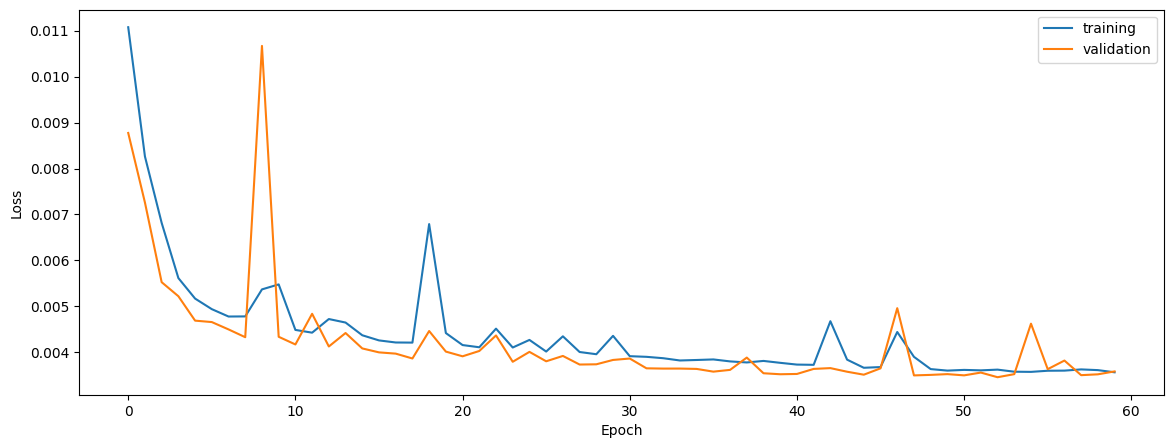

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8008580700128698
0.795409406116655
0.7782460884599592


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8008580700128698
0.795409406116655
0.7782460884599592


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8045744441495667
0.7941751190675654
0.7828693878866256


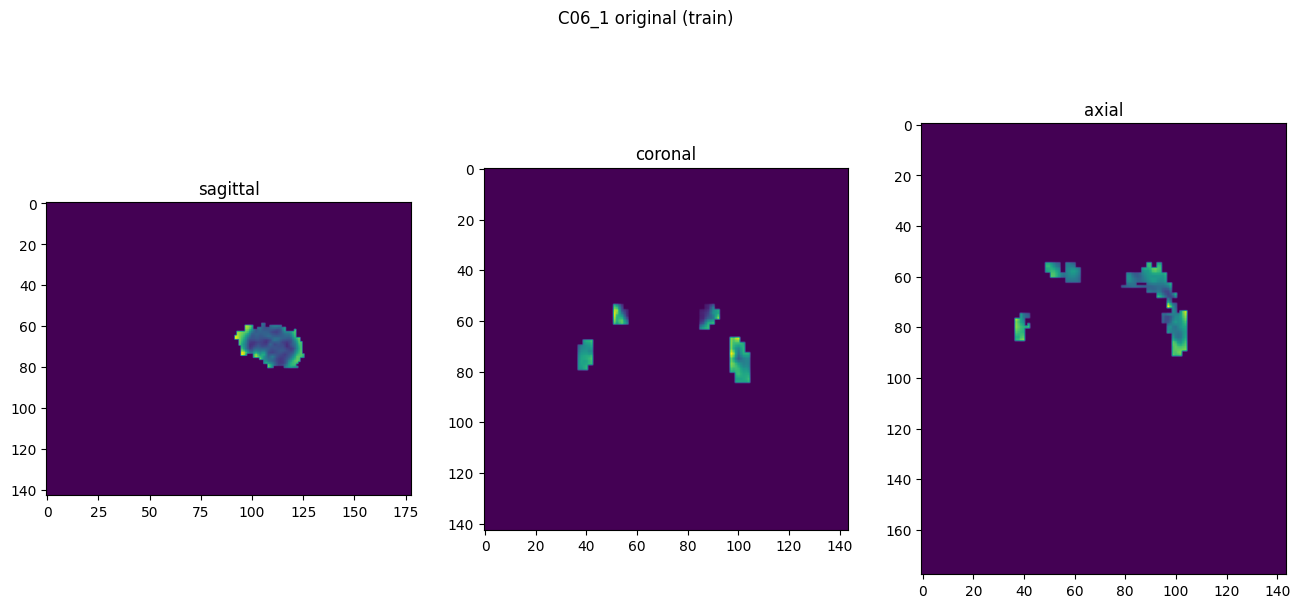

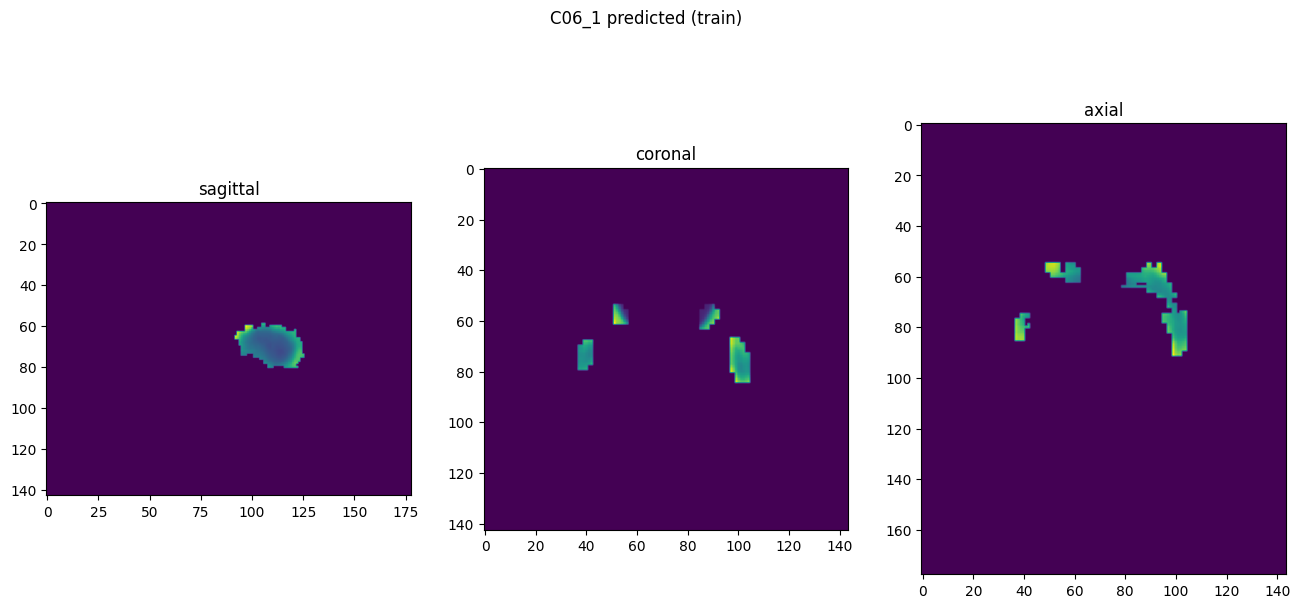

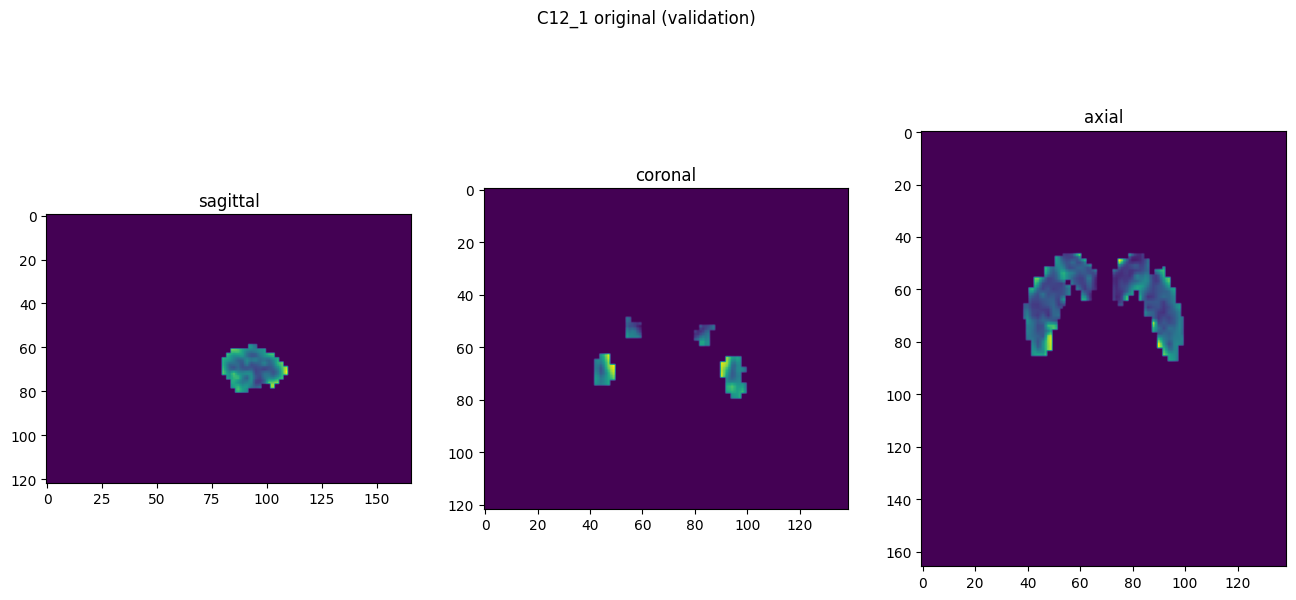

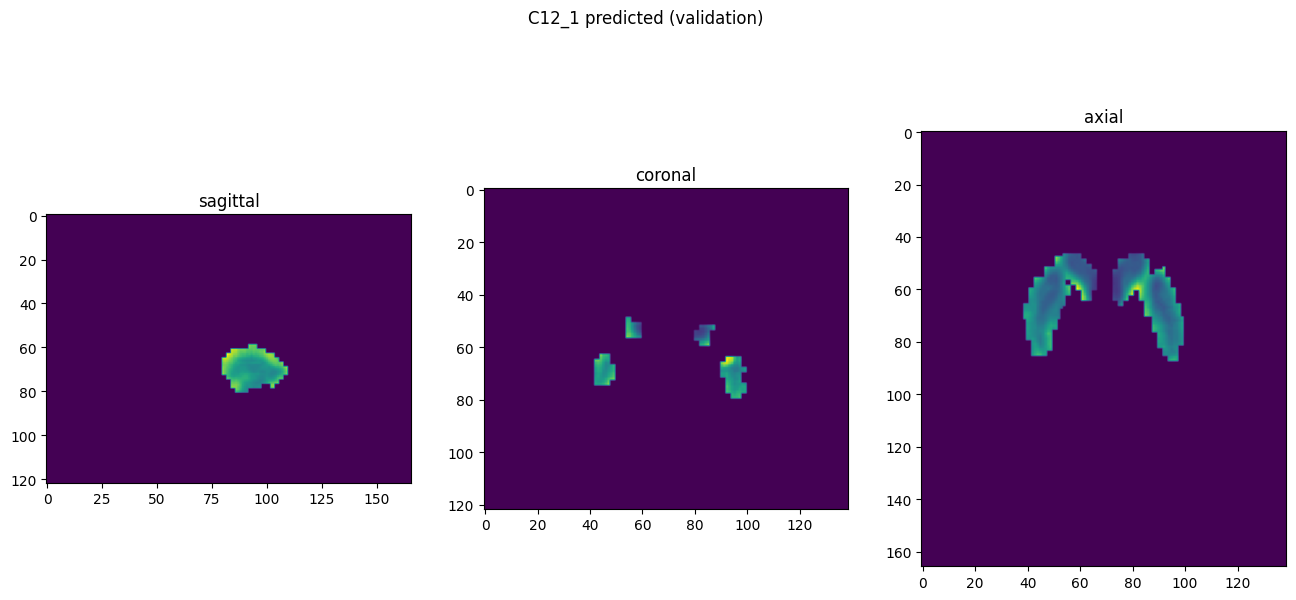

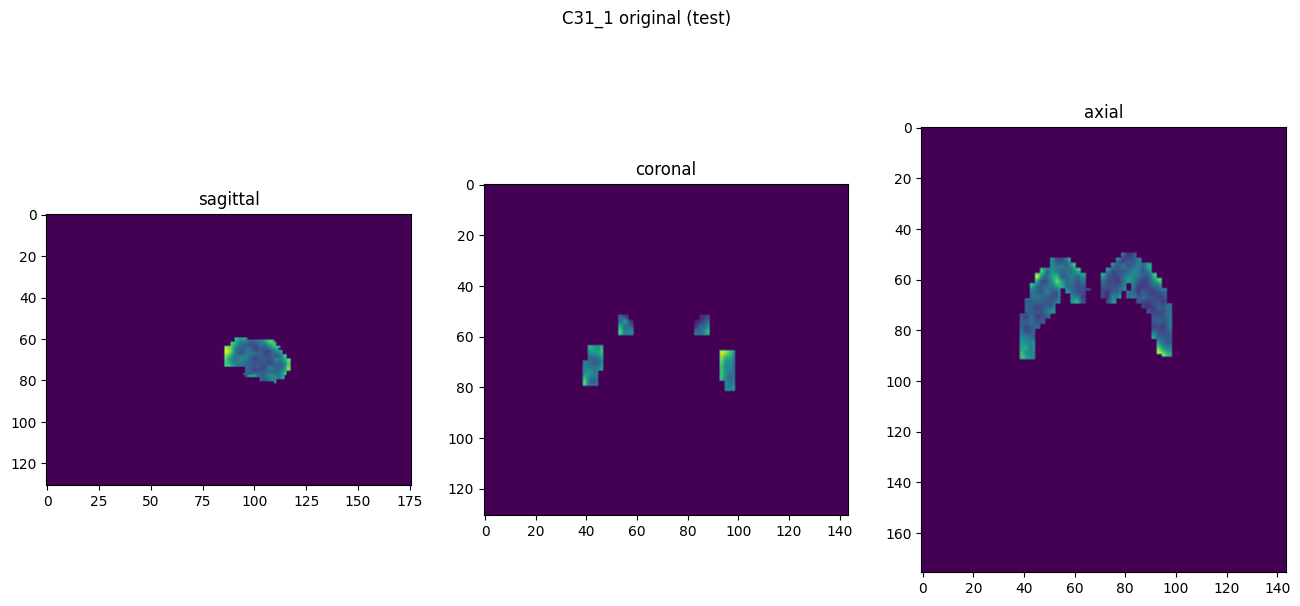

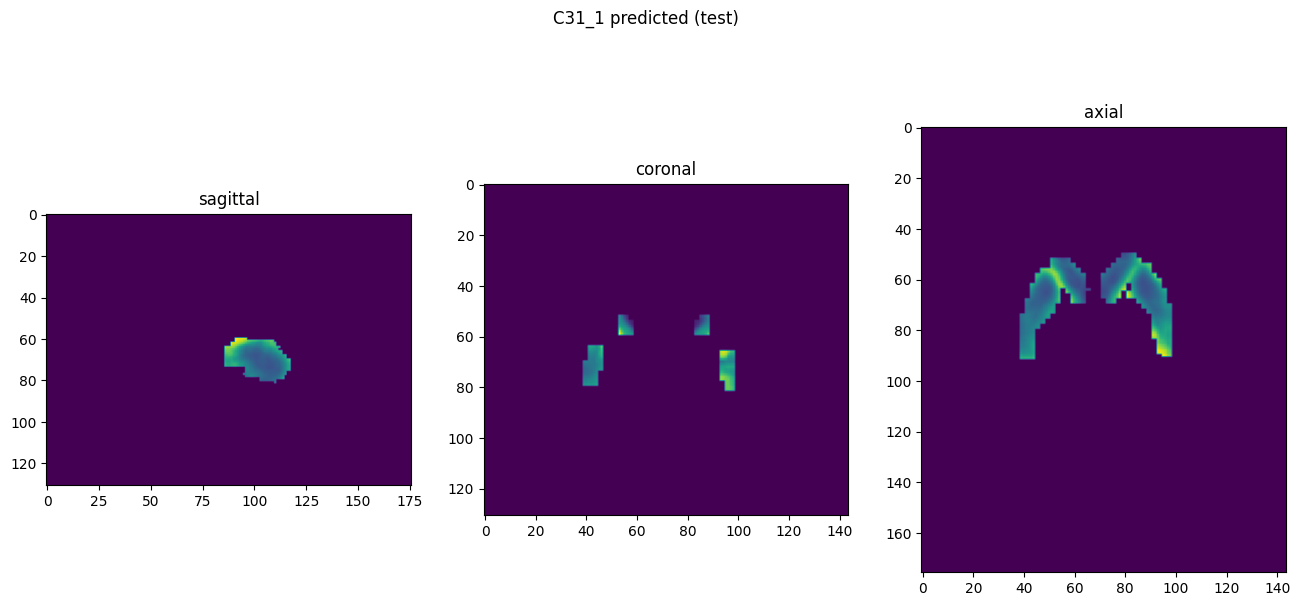

In [10]:
showResults(model, gen, threshold=None, background=False)